In [142]:
from zipfile import ZipFile, Path
import pandas as pd
import plotly.express as px
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster 

In [143]:
def get_data(path: str) -> pd.DataFrame:
    '''
    Get data from zip file
    '''
    with ZipFile(path) as myzip:
        data = myzip.open(path.split('.zip')[0])

    df = pd.read_csv(data, sep =';')
    return df

In [144]:
df_2021_2022 = get_data("DMR_2021_2022.csv.zip")
df_2020 = get_data("DMR_2020.csv.zip")
df_2019 = get_data("DMR_2019.csv.zip")

In [145]:
df_2021_2022[['X', 'Y']] = df_2021_2022['geo_point_2d'].str.split(',', expand=True)


In [146]:
df_2021_2022 = df_2021_2022.drop(['ID DECLARATION', 'VILLE', 'ANNEE DECLARATION', 'MOIS DECLARATION',
         'OUTIL SOURCE', 'ID_DMR', 'geo_shape', 'geo_point_2d', 'CONSEIL DE QUARTIER'], axis = 1)

In [147]:
df_2019_2020 = pd.concat([df_2019, df_2020])
df_2019_2020 = df_2019_2020.drop(['OBJECTID', 'ID_DMR', 'VILLE' ,'ANNEEDECL' ,'MOISDECL' ,'NUMERO','PREFIXE', 'CONSEILQUARTIER',  ], axis = 1)


In [148]:
df_2019_2020.rename(columns = {'TYPE':'TYPE DECLARATION', 'SOUSTYPE':'SOUS TYPE DECLARATION', 'CODE_POSTAL':'CODE POSTAL', 'DATEDECL':'DATE DECLARATION'}, inplace = True)
df_2019_2020.rename(columns = {'Y':'LONGITUDE', 'X':'LATITUDE'}, inplace = True)
df_2021_2022.rename(columns = {'X':'LONGITUDE', 'Y':'LATITUDE'}, inplace = True)
df_final = pd.concat([df_2021_2022, df_2019_2020])


In [149]:
df_final.head()

,TYPE DECLARATION,SOUS TYPE DECLARATION,ADRESSE,CODE POSTAL,ARRONDISSEMENT,DATE DECLARATION,INTERVENANT,LONGITUDE,LATITUDE
0,Mobiliers urbains,Collecte des déchets:Trilib' dégradé,"18 Rue de Mazagran, 75010 PARIS",75010,10,2021-01-08,TRILIB',48.8707730016144,2.352240998304316
1,Objets abandonnés,Autres objets encombrants abandonnés,"58 Rue de l'Aqueduc, 75010 PARIS",75010,10,2021-01-08,Ramen en tant que prestataire de DansMaRue,48.88284700351721,2.365264406238782
2,Objets abandonnés,Autres objets encombrants abandonnés,"106 Rue des Amandiers, 75020 PARIS",75020,20,2021-01-08,Ramen en tant que prestataire de DansMaRue,48.86777999827195,2.388730996327768
3,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","14 Rue Carrière-Mainguet, 75011 PARIS",75011,11,2021-01-08,graffitis,48.856599995660474,2.387607803079172
4,Objets abandonnés,Cartons,"1 Square Alfred Capus, 75016 PARIS",75016,16,2021-01-08,DPE-STPP-DT,48.85093700329557,2.259631402809926


In [150]:
arrondissement_count = df_final["ARRONDISSEMENT"].value_counts()

fig = px.bar(arrondissement_count, x=arrondissement_count.index, y='ARRONDISSEMENT',
             hover_data=[arrondissement_count.index, 'ARRONDISSEMENT'], color='ARRONDISSEMENT',
             labels={'index': "District number",'ARRONDISSEMENT':'District'}, height=400)
fig.update_xaxes(type='category')
fig.show()
# USE INDEX AS X AXIS

In [151]:

fig = px.pie(arrondissement_count, values='ARRONDISSEMENT',
            names=arrondissement_count.index, 
            title='Pie chart of anomalies by district',
            color='ARRONDISSEMENT',
            color_discrete_sequence=px.colors.cyclical.IceFire,
            labels={'index': "Number", 'ARRONDISSEMENT': 'Anomalies' }, height=400)
fig.update_layout(width=1000,
    height=700,
    legend_title_text='District'
)

fig.show()

In [152]:
df_final['LONGITUDE'] = df_final['LONGITUDE'].apply(lambda x: x.replace(',','.'))
df_final['LATITUDE'] =  df_final['LATITUDE'].apply(lambda x: x.replace(',','.'))


In [153]:

df_final['LONGITUDE'] = df_final['LONGITUDE'].astype(float)
df_final['LATITUDE'] = df_final['LATITUDE'].astype(float)
locations_x = df_final['LONGITUDE'].mean()
location_y = df_final['LATITUDE'].mean()

In [154]:
paris = folium.Map(location = [locations_x, location_y], tiles="Stamen Terrain",zoom_start = 12)
df_final_1000 = df_final.sample(1000)
marker_cluster = MarkerCluster(
    name='1000 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)
for index, location_info in df_final_1000.iterrows():
    marker = folium.Marker([location_info["LONGITUDE"], location_info["LATITUDE"]])
    popup='Type: {}<br>Arrondisement: {} <br> Adresse: {} <br>  Date declaration {}'.format(
                                                            location_info["TYPE DECLARATION"], 
                                                            location_info["ARRONDISSEMENT"],
                                                            location_info["ADRESSE"],
                                                            location_info['DATE DECLARATION'])
    folium.Popup(popup, min_width=300, max_width=300).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(paris)

folium.LayerControl().add_to(paris)

paris

In [155]:
df_district = df_final.groupby(['ARRONDISSEMENT'], as_index=False).agg({'LONGITUDE': 'mean'
                                                                        , 'LATITUDE': 'mean'
                                                                        , 'TYPE DECLARATION': 'count'})
df_district['RATIO_ANOMALIES'] = df_district['TYPE DECLARATION'] / df_district['TYPE DECLARATION'].sum()
df_district['RATIO_ANOMALIES'] = df_district['RATIO_ANOMALIES'].multiply(7000).astype(int)
districts_map = folium.Map(location = [locations_x, location_y], tiles="Stamen Terrain",zoom_start = 13)

tooltip = "Click me!"

for index, location_info in df_district.iterrows():
    circle = folium.Circle(
    location=[location_info["LONGITUDE"], location_info["LATITUDE"]],
    radius=location_info["RATIO_ANOMALIES"],
    color="#3186cc",
    popup='District: {} <br> Anomalies: {}<br> '.format(
                                                            int(location_info["ARRONDISSEMENT"]),
                                                            int(location_info["TYPE DECLARATION"]), 
                                                            ),
    fill=True,
    tooltip=tooltip,
    fill_color="#3186cc",
)
    circle.add_to(districts_map)


folium.LayerControl().add_to(districts_map)
districts_map

In [156]:
df_final['TYPE DECLARATION'].replace(['Autos, motos, vélos... '],'Autos, motos, vélos...',inplace = True)

df_count_type = df_final['TYPE DECLARATION'].value_counts()

fig = px.histogram(df_count_type, y = df_count_type.index, x = 'TYPE DECLARATION',
            color='TYPE DECLARATION',
            width=1200, height=500,
            orientation='h',
            title='Histogram of anomalies by type',
            labels = {'index': 'Type', 'TYPE DECLARATION': 'Total'},)
fig.show()

In [187]:

df_count_sous_type_20 = df_final['SOUS TYPE DECLARATION'].value_counts()
# without the first row because it has like 4000 k counted value
df_count_sous_type_20 = df_count_sous_type_20[1:20]
fig = px.bar(df_count_sous_type_20, y = df_count_sous_type_20.index, x = 'SOUS TYPE DECLARATION',
            color='SOUS TYPE DECLARATION',
            width=1200, height=600,
            title='Histogram of sub types of declaration',
            orientation='h',
            labels = {'index': 'Type', 'SOUS TYPE DECLARATION': 'Total'},)
fig.show()

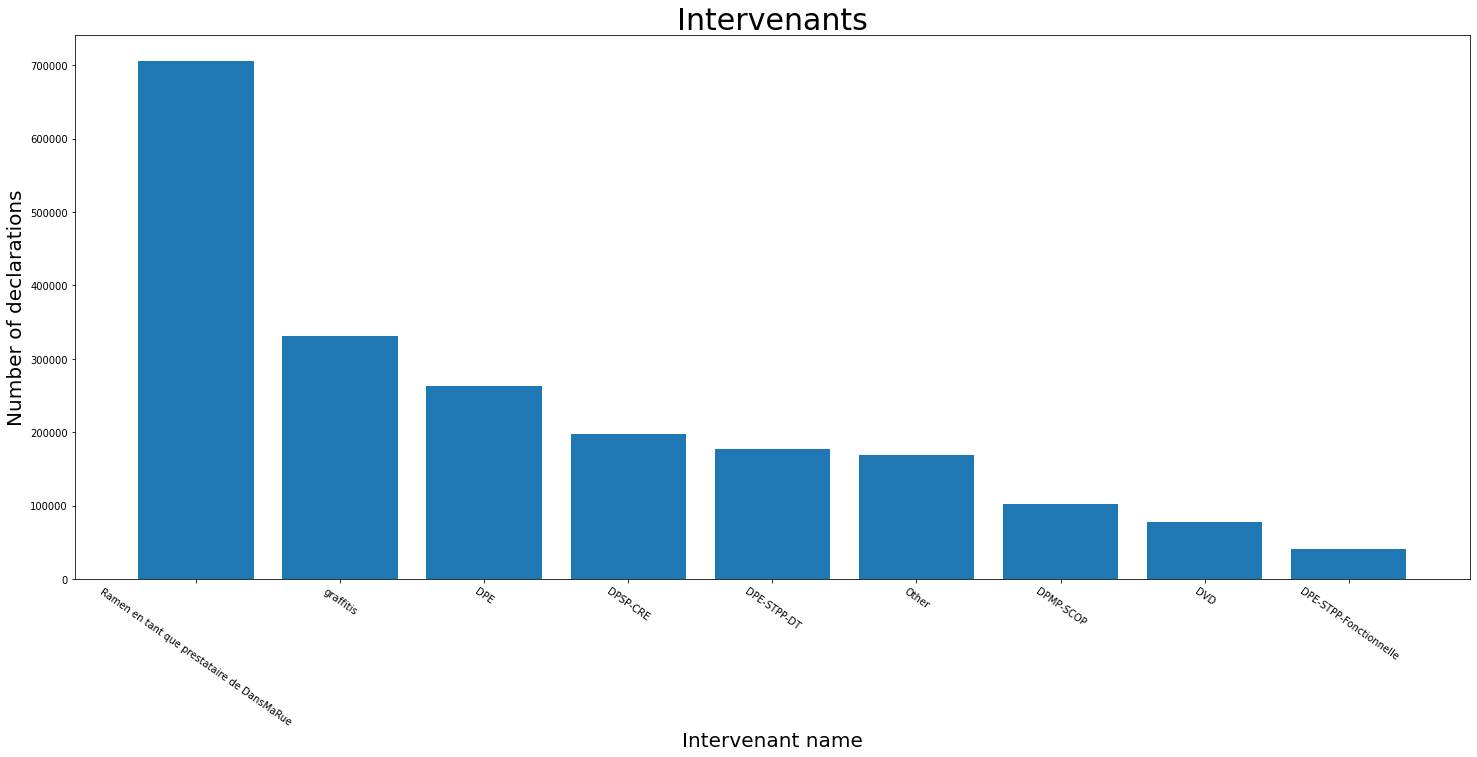

In [158]:
df_final['DATE DECLARATION'] = pd.to_datetime(df_final['DATE DECLARATION'],
                                                infer_datetime_format = True,
                                                dayfirst = True)
df_intervenants = df_final.groupby(['INTERVENANT'])['TYPE DECLARATION'].count().sort_values(ascending = False)
df_intervenants['Other'] = df_intervenants[8:].sum()
df_intervenants = df_intervenants.sort_values(ascending=False)
df_intervenants = df_intervenants[:9]

plt.figure(figsize=(25,10))
plt.title('Intervenants', size=30)
plt.xlabel('Intervenant name', size=20)
plt.ylabel('Number of declarations', size=20)
plt.xticks(rotation=-35)

plt.bar(x= df_intervenants.index, height=df_intervenants.values)

plt.show()


<AxesSubplot:title={'center':'Devices'}, xlabel='OUTIL SOURCE', ylabel='Number of declarations'>

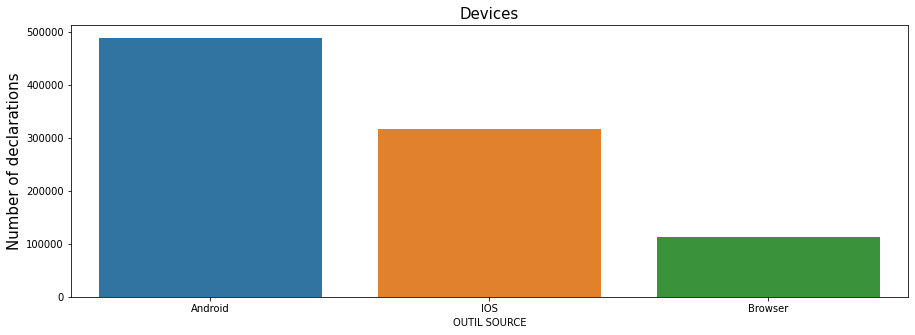

In [159]:
df_2021_2022 = get_data('DMR_2021_2022.csv.zip')
devices = df_2021_2022.groupby('OUTIL SOURCE')['OUTIL SOURCE'].count()
devices.drop('Back Office', inplace = True)
devices.rename({'Androï': 'Android','IOPage DMR Paris.fr application': 'IOS', 'Page DMR Paris.fr': 'Browser' }, inplace = True)
plt.figure(figsize=(15,5))
plt.title('Devices', size=15)
plt.xlabel('Device name', size=10)
plt.ylabel('Number of declarations', size=15)
sns.barplot(x=devices.index, y=devices.values, )

<AxesSubplot:title={'center':'Correlation matrix'}>

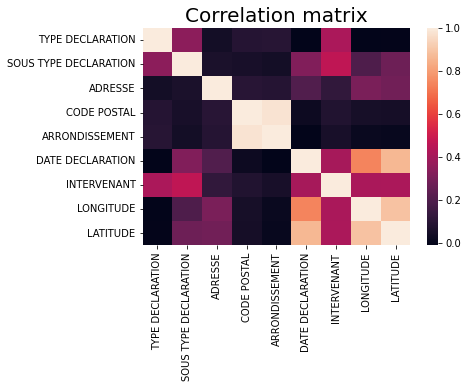

In [160]:
df_pearson_matrix = df_final.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
plt.title('Correlation matrix', size=20)

sns.heatmap(df_pearson_matrix)

In [193]:
df1 = pd.read_csv('ECA_blended_custom/TG_STAID011249.txt',comment='#')
df1.columns = df1.columns.str.replace(' ', '')

df1['TG']=df1['TG']/10
df1=df1[df1['TG'] > -273.15]
df1.drop(['SOUID', 'Q_TG'], axis=1, inplace=True)
df1.index=pd.to_datetime(df1['DATE'],format="%Y%m%d")
df1.drop('DATE', axis=1,inplace=True)
df1.head()

,TG
DATE,
1921-03-01,5.0
1921-03-02,4.6
1921-03-03,4.6
1921-03-04,3.1
1921-03-05,9.5


<AxesSubplot:xlabel='DATE'>

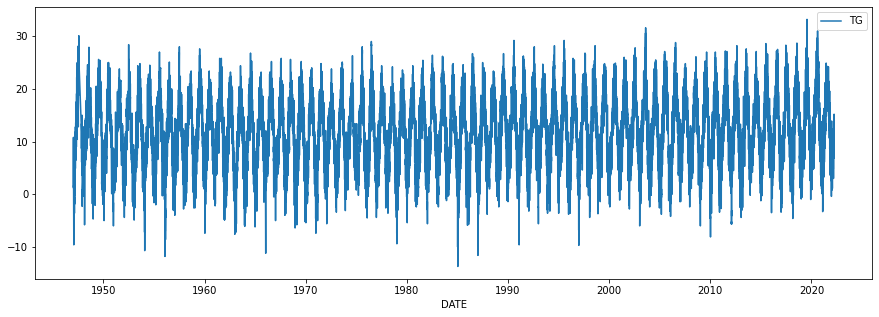

In [220]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df1['1947-01-08':])

#plt.plot(df1.loc['1947-01-08':])
#df1.loc['':]
